# Bowman's Model

## Import necessary packages

In [1]:
import torch
import torch.nn as nn

from torchtext import data
from torchtext.data import Dataset
from torchtext import datasets
from torchtext.vocab import GloVe

from nltk import word_tokenize
import time
import dill

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Make directories
Make directories for saving data and model.

In [2]:
import os
from os.path import join

# claim directories for saving data and model
new_dir = ['./data', './model', './data/snli_split']

# if directories not exist, make new directory
for dir in new_dir:
    if not os.path.exists(dir):
        print('mkdir:', dir)
        os.mkdir(dir)

mkdir: ./data
mkdir: ./model
mkdir: ./data/snli_split


## SNLI corpus data preprocessing
The class to preprocess SNLI corpus.

For the first time on initial, the initial function will download and split SNLI corpus to train, dev and test sets, build vocab for the corpus by using Glove 840B 300d and store them to local files. And it will also generate batch iterator for the sets. This process may take more than 5 minutes on first time.

After the first time, initial function will check existence of local files, if exists, it will load directly from local file and thus can save a lot of time (within 1 minute).

In [0]:
class SNLIDataset(Dataset):
    @staticmethod
    def sort_key(ex):
        return data.interleave_keys(len(ex.premise), len(ex.hypothesis))

# preprocess SNLI corpus to save time and give train, dev, test sets
class SNLI(object):
    def __init__(self, batch_size=4, gpu=torch.device('cuda')):
        # set file name for train dev test sets
        self.snli_split_path_lst = ['./data/snli_split/train', './data/snli_split/dev', './data/snli_split/test']

        # set data field for text and label
        self.TEXT = data.Field(batch_first=True, include_lengths=True, tokenize=word_tokenize, lower=True)
        self.LABEL = data.Field(sequential=False, unk_token=None)

        # split corpus
        if self.if_splited():
            # if already splited, load local sets
            fields = {'premise': self.TEXT, 'hypothesis': self.TEXT, 'label': self.LABEL}
            self.train, self.dev, self.test = self.load_split_datasets(fields)
        else:
            # split corpus to train, dev, test sets and save them to local
            self.train, self.dev, self.test = datasets.SNLI.splits(self.TEXT, self.LABEL, root='data')
            self.save_splited_sets(self.train, self.dev, self.test)


        # build vocab for corpus
        if os.path.exists('./data/snli_split/text_vocab') and os.path.exists('./data/snli_split/label_vocab'):
            # if local vocab exists, load local vocab into model
            with open('./data/snli_split/text_vocab', 'rb')as f:
                self.TEXT.vocab = dill.load(f)
            with open('./data/snli_split/label_vocab', 'rb')as f:
                self.LABEL.vocab = dill.load(f)
        else:
            # build vocab for corpus and save it to local
            self.TEXT.build_vocab(self.train, self.dev, self.test, vectors=GloVe(name='840B', dim=300))
            self.LABEL.build_vocab(self.train)
            with open('./data/snli_split/text_vocab', 'wb')as f:
                dill.dump(self.TEXT.vocab, f)
            with open('./data/snli_split/label_vocab', 'wb')as f:
                dill.dump(self.LABEL.vocab, f)


        # generate batch iterator
        self.train_iter, self.dev_iter, self.test_iter =  data.BucketIterator.splits((self.train, self.dev, self.test), batch_size=batch_size, device=gpu)

    # check local train, dev, test sets
    def if_splited(self):
        for path in self.snli_split_path_lst:
            if not os.path.exists(path):
                return False
        return True

    # load dataset from local
    def load_split_datasets(self, fields):
        # load from local
        with open('./data/snli_split/train', 'rb')as f:
            train_examples = dill.load(f)
        with open('./data/snli_split/dev', 'rb')as f:
            dev_examples = dill.load(f)
        with open('./data/snli_split/test', 'rb')as f:
            test_examples = dill.load(f)

        # recover
        train = SNLIDataset(examples=train_examples, fields=fields)
        dev = SNLIDataset(examples=dev_examples, fields=fields)
        test = SNLIDataset(examples=test_examples, fields=fields)
        return train, dev, test

    # save datasets to local
    def save_splited_sets(self, train, dev, test):
        # save to local
        with open('./data/snli_split/train', 'wb')as f:
            dill.dump(train.examples, f)
        with open('./data/snli_split/dev', 'wb')as f:
            dill.dump(dev.examples, f)
        with open('./data/snli_split/test', 'wb')as f:
            dill.dump(test.examples, f)

## Initialize SNLI class and do preprocessing

In [4]:
device = torch.device('cuda')
snli = SNLI(batch_size=32, gpu=device)

downloading snli_1.0.zip


snli_1.0.zip: 100%|██████████| 94.6M/94.6M [00:07<00:00, 12.3MB/s]


extracting


.vector_cache/glove.840B.300d.zip: 2.18GB [17:00, 2.13MB/s]                           
100%|█████████▉| 2195732/2196017 [04:56<00:00, 7907.78it/s]

## Bowman's Model

In [0]:
class Bowman(nn.Module):
    def __init__(self, vocab, premise_emb=300, hypothesis_emb=300, premise_d=100, hypothesis_d=100, lstm_layers=1, dropout=0.1):
        super(Bowman, self).__init__()
        # vocab - vocab built for corpus
        # premise_emb - word embedding size for tokens in premise
        # hypothesis_emb - word embedding size for tokens in hypothesis
        # premise_d - sentence embedding size for premise
        # hypothesis_d - sentence embedding size for hypothesis
        # lstm_layers - layer number for LSTM model
        # dropout - dropout rate for the model
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.dropout = nn.Dropout(dropout)
        self.Premise_Enc = nn.LSTM(input_size=premise_emb, hidden_size=premise_d, num_layers=lstm_layers, batch_first=True)
        self.Hypothesis_Enc = nn.LSTM(input_size=hypothesis_emb, hidden_size=hypothesis_d, num_layers=lstm_layers, batch_first=True)
        self.tanh = nn.Tanh()
        self.out = nn.Linear(premise_d + hypothesis_d, 3) # batch_size x 3

    def forward(self, premise_seq, hypothesis_seq):
        premise_seq = self.embedding(premise_seq) # batch_size x seq_len -> batch_size x seq_len x 300
        hypothesis_seq = self.embedding(hypothesis_seq) # batch_size x seq_len -> batch_size x seq_len x 300
        premise_seq = self.dropout(premise_seq)
        hypothesis_seq = self.dropout(hypothesis_seq)

        premise_output, _  = self.Premise_Enc(premise_seq) # batch_size x seq_len x 300 -> batch_size x seq_len x 100
        hypothesis_output, _  = self.Hypothesis_Enc(hypothesis_seq) # batch_size x seq_len x 300 -> batch_size x seq_len x 100
        premise_output = torch.mean(premise_output, 1) # batch_size x seq_len x 100 -> batch_size x 100
        hypothesis_output = torch.mean(hypothesis_output, 1) # batch_size x seq_len x 100 -> batch_size x 100
        next_in = torch.cat((premise_output, hypothesis_output), 1)  # [batch_size x 100, batch_size x 100] -> batch_size x 200
        #next_in = torch.cat((premise_output[ :, -1, :],hypothesis_output[ :, -1, :]), 1)
        next_in = self.dropout(next_in)
        tanh_out = self.tanh(self.tanh(self.tanh(next_in)))
        output = self.out(tanh_out) # batch_size x 200 -> batch_size x 3
        return output

## Train function

In [0]:
def bowman_train(model, dataset, criterion, optimizer, epoch_num=5):
    # model - model
    # dataset - traning set
    # criterion - loss function
    # optimizer - optimize function
    # epoch_num - epoch number
    snli = dataset
    # file to record average loss for each epoch
    record = open("result.txt", "wb", buffering=0)
    for epoch in range(epoch_num):
        # switch to train mode
        model.train()

        for batch in snli.train_iter:
            # get data
            premise, _ = batch.premise
            hypothesis, _ = batch.hypothesis
            label = batch.label

            # zeros the parameters gradients
            optimizer.zero_grad()

            # forward + backward + optimize step
            output = model(premise, hypothesis)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

        train_acc, train_loss = bowman_eval(model, dataset, "Train", criterion)
        dev_acc, dev_loss = bowman_eval(model, dataset, "Dev", criterion)
        # print average loss for the epoch
        print('epoch %d train_loss: %.3f dev_loss: %.3f train_acc: %.3f dev_acc: %.3f' % (epoch, train_loss, dev_loss, train_acc, dev_acc))
        # save average loss for the epoch
        record.write(b'%f\t%f\t%f\t%f\n' % (train_loss, dev_loss, train_acc, dev_acc))
        # save trained model after the epoch
        torch.save(model.state_dict(), './model/bowman_%d.pth'% (epoch))

    # save final trained model
    torch.save(model.state_dict(), './model/bowman_final.pth')

## Evaluation

In [0]:
def bowman_eval(model, dataset, set_name, criterion):
    # model - model
    # dataset - evaluation set
    snli = dataset

    # switch to evaluation mode
    model.eval()

    batch_iter = None

    if set_name == "Train":
        batch_iter = snli.train_iter
    elif set_name == "Dev":
        batch_iter = snli.dev_iter
    elif set_name == "Test":
        batch_iter = snli.test_iter
    else:
        return

    c_count = 0.
    t_count = 0.
    epoch_loss = 0.0
    for batch in batch_iter:
        # get data
        premise, _ = batch.premise
        hypothesis, _ = batch.hypothesis
        label = batch.label

        # do predict
        output = model(premise, hypothesis)
        predict = torch.argmax(output, dim=1)
        loss = criterion(output, label)
        batch_size = predict.shape

        epoch_loss += loss.item() * batch_size[0]

        # total number
        t_count += batch_size[0]
        # correct number
        c_count += int(torch.sum(predict == label))
    # calcualte the accuracy and print it out
    # print("%s acc.: %f" % (set_name, c_count / t_count))
    return c_count / t_count, epoch_loss / t_count

## Train the model
Initial model, use cross entropy loss and Adam Delta SGD as optimize function.

In [14]:
model = Bowman(snli.TEXT.vocab)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)

bowman_train(model, snli, criterion, optimizer, epoch_num=5)

epoch 0 train_loss: 1.008 dev_loss: 1.031 train_acc: 0.505 dev_acc: 0.480
epoch 1 train_loss: 0.919 dev_loss: 0.946 train_acc: 0.572 dev_acc: 0.571
epoch 2 train_loss: 0.888 dev_loss: 0.928 train_acc: 0.595 dev_acc: 0.582
epoch 3 train_loss: 0.867 dev_loss: 0.918 train_acc: 0.608 dev_acc: 0.588
epoch 4 train_loss: 0.851 dev_loss: 0.906 train_acc: 0.617 dev_acc: 0.594


## Evaluate on Train and Test set

In [21]:
model = Bowman(snli.TEXT.vocab)
model.load_state_dict(torch.load("./model/bowman_final.pth"))
model.to(device)
acc, loss = bowman_eval(model, snli, "Train", criterion)
print("Train acc.: %.3f, loss : %.3f" % (acc, loss))
acc, loss = bowman_eval(model, snli, "Test", criterion)
print("Test acc.: %.3f, loss : %.3f" % (acc, loss))

Train acc.: 0.617, loss : 0.851
Test acc.: 0.585, loss : 0.909


Result for first 5 sentences in test set.

In [16]:
#device = torch.device('cuda')

#snli = SNLI(batch_size=32, gpu=device)
#model = Bowman(snli.TEXT.vocab)
#model.load_state_dict(torch.load("./model/bowman_64.pth"))
#model.to(device)

# first 5 premises with hypothesis
premises = ["This church choir sings to the masses as they sing joyous songs from the book at a church.",
"This church choir sings to the masses as they sing joyous songs from the book at a church.",
"This church choir sings to the masses as they sing joyous songs from the book at a church.",
"A woman with a green headscarf, blue shirt and a very big grin.",
"A woman with a green headscarf, blue shirt and a very big grin."]

hypothesis = ["The church has cracks in the ceiling.",
"The church is filled with song.",
"A choir singing at a baseball game.",
"The woman is young.",
"The woman is very happy."]

# ground truth
gold_label = ["neural", "entailment", "contradiction", "neural", "entailment"]

# tokenize
premises_token = [snli.TEXT.preprocess(x) for x in premises]
hypothesis_token = [snli.TEXT.preprocess(x) for x in hypothesis]

# label list
label_vocab = snli.LABEL.vocab.itos
preds = []

for i in range(len(premises)):
    # token to index in vocab
    prem, _ = snli.TEXT.numericalize(([premises_token[i]],[len(premises_token[i])]), device=device)
    hypo, _ = snli.TEXT.numericalize(([hypothesis_token[i]],[len(hypothesis_token[i])]), device=device)
    # do prediction
    output = model(prem, hypo)
    lab = label_vocab[int(torch.argmax(output))]
    preds.append(lab)

# print results
for i in range(len(premises)):
    print("Premise: " + premises[i])
    print("Hypothesis: " + hypothesis[i])
    print("Model Output: " + preds[i])
    print("Ground Truth: " + gold_label[i])
    print()

Premise: This church choir sings to the masses as they sing joyous songs from the book at a church.
Hypothesis: The church has cracks in the ceiling.
Model Output: contradiction
Ground Truth: neural

Premise: This church choir sings to the masses as they sing joyous songs from the book at a church.
Hypothesis: The church is filled with song.
Model Output: contradiction
Ground Truth: entailment

Premise: This church choir sings to the masses as they sing joyous songs from the book at a church.
Hypothesis: A choir singing at a baseball game.
Model Output: contradiction
Ground Truth: contradiction

Premise: A woman with a green headscarf, blue shirt and a very big grin.
Hypothesis: The woman is young.
Model Output: neutral
Ground Truth: neural

Premise: A woman with a green headscarf, blue shirt and a very big grin.
Hypothesis: The woman is very happy.
Model Output: neutral
Ground Truth: entailment



## Plot train result

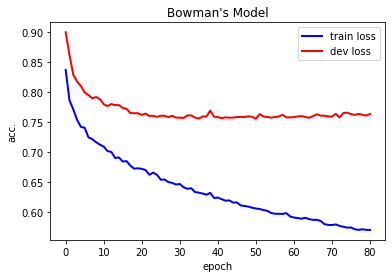

In [22]:
import matplotlib.pyplot as plt

train_loss = []
train_acc = []
dev_loss = []
dev_acc = []

with open("result.txt", "rb") as f:
    for line in f:
        line = [float(x) for x in line.strip().split()]
        train_loss.append(line[0])
        dev_loss.append(line[1])
        train_acc.append(line[2])
        dev_acc.append(line[3])

x = range(len(train_loss))

plt.plot(x, train_loss, label='train loss',linewidth=2,color='b') 
plt.plot(x, dev_loss, label='dev loss',linewidth=2,color='r') 
plt.xlabel('epoch')
plt.ylabel('acc.')
plt.title('Bowman\'s Model')
plt.legend()
plt.show()